In [101]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import pandas as pd
import scipy.stats as ss
import numpy.random as npr

### Log-Normal Property of Stock Price

In [45]:
df = pd.read_csv("market_data.xls")
df1 = df["PPE.JO"]

#Use Purple Group
print(df1.head())

0    49.955502
1    49.955502
2    44.078300
3    44.078300
4    47.996399
Name: PPE.JO, dtype: float64


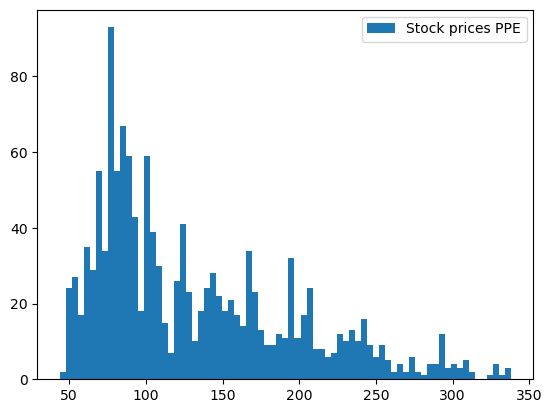

In [46]:
plt.hist(df1, bins=75, label="Stock prices PPE")
plt.legend()
plt.show()

Conveniently, the log-transform of a log-normally distributed variable will follow a normal distribution.

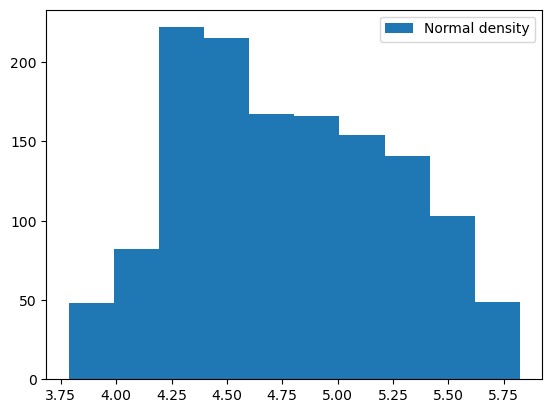

In [47]:
df2 = np.log(df1)
plt.hist(df2, label="Normal density")
plt.legend()
plt.show()

### Geometric Brownian Motion (GBM)

$$dS = S_0 (\mu dt + \sigma dW_t)$$

236.14602030745


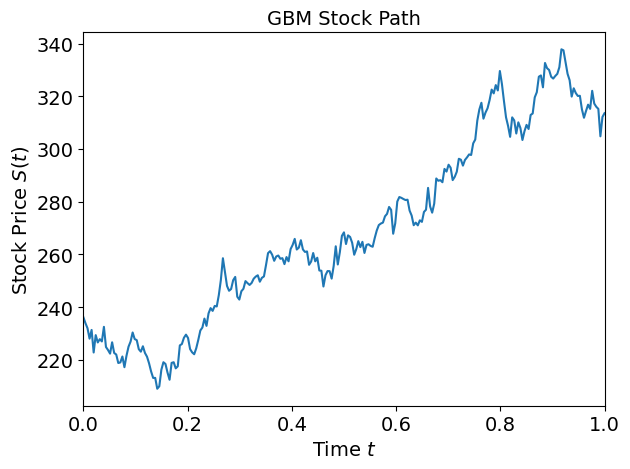

In [131]:
fig = plt.figure()
np.random.seed(1)

#Set parameters
T = 1  # years
N = 255  # Number of points, number of subintervals = N-1
dt = T / N  # Time step in "years"
t = np.linspace(0, T, N)
M = 1  # Number of paths (Monte Carlo approach)
vol = 0.26
S0 = 230
mu = 0.07  # drift

## GBM
dS = S0 * (mu * dt + vol * np.sqrt(dt) * np.random.randn(M, N))
S = S0 + np.cumsum(dS, axis=1) #Sum past values

for i in range(M):
    plt.plot(t, S[i, :])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("Stock Price $S(t)$", fontsize=14)
plt.title("GBM Stock Path", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

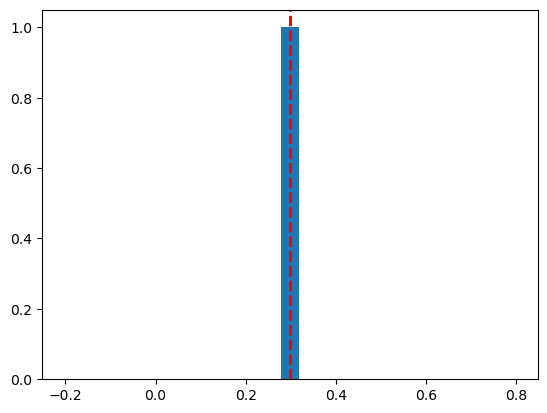

In [13]:
#Plot price path in histogram
Returns = (S[:, -1] - S[:, 0]) / S[:, 0] #Calc stock return
plt.hist(Returns, bins=25)

#Indicate 10th & 90th percentiles
plt.axvline(np.percentile(Returns, 10), color="r", linestyle="dashed", linewidth=2)
plt.axvline(np.percentile(Returns, 90), color="r", linestyle="dashed", linewidth=2)

plt.show()

### Pricing a Call Option with Black-Scholes

$$c = S_0 N(d_1) - K e^{-rT} N(d_2)$$

In [48]:
def bs_call_price(S, r, sigma, t, T, K):
    ttm = T - t #Time to maturity

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        return np.maximum(S - K, 0.0) # Call Payoff

    vol = sigma * np.sqrt(ttm)
    
    #d2
    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol
    
    #d1
    d_plus = d_minus + vol

    res = S * norm.cdf(d_plus)
    res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)

    return res

In [126]:
bs_call_price(S=62.5, r=0.0325, sigma=0.55, t=0, T=3/12, K=55)

6.391440240040197

### Pricing a Put Option with Black-Scholes

$$p = K e^{-rT} N(d_2) - S_0 N(- d_1)$$

In [121]:
def bs_put_price(S, r, sigma, t, T, K, seed=42):
    np.random.normal(seed)
    ttm = T - t #Time to maturity

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        return np.maximum(K - S, 0.0) # Put Payoff

    vol = sigma * np.sqrt(ttm)
    
    #d2
    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol
    
    #d1
    d_plus = d_minus + vol

    res = K * np.exp(-r * ttm) * norm.cdf(-d_minus)
    
    res -= S * norm.cdf(-d_plus)

    return res

In [133]:
bs_put_price(S=32.5, r=0.0275, sigma=0.45, t=0, T=4/12, K=27.5)

1.1405087663931308

### Greeks

Use Greeks to hedge away the different risks in the portfolio

In [54]:
def greeks(S, K, r, vol, T, div_yield = 0, option_type = "C"):
    # Compute d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    if option_type in ["C", "P"]:
        
        #Calc Greeks
        if option_type in ["C"]: #For Call Options
            Opt_Price = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
            Delta = ss.norm.cdf(d1)
            Gamma = ss.norm.pdf(d1) / (S * vol * np.sqrt(T))
            Vega = S * ss.norm.pdf(d1) * np.sqrt(T)
            Theta = -(S * ss.norm.pdf(d1) * vol) / (2 * np.sqrt(T)) - r * K * np.exp(
                -r * T) * ss.norm.cdf(d2)
            Rho = K * T * np.exp(-r * T) * ss.norm.cdf(d2)
        
        else: #For Put Options
            Opt_Price = K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
            Delta = -ss.norm.cdf(-d1)
            Gamma = ss.norm.pdf(d1) / (S * vol * np.sqrt(T))
            Vega = S * ss.norm.pdf(d1) * np.sqrt(T)
            Theta = -(S * ss.norm.pdf(d1) * vol) / (2 * np.sqrt(T)) + r * K * np.exp(
                -r * T) * ss.norm.cdf(-d2)
            Rho = -K * T * np.exp(-r * T) * ss.norm.cdf(-d2)
            
    else:
        Opt_Price = "Error: option type incorrect. Choose P for a put option or C for a call option."

    print("Option price = {}".format(Opt_Price))
    print("Delta = {}".format(Delta))
    print("Gamma = {}".format(Gamma))
    print("Vega = {}".format(Vega))
    print("Theta = {}".format(Theta))
    print("Rho = {}".format(Rho))

In [132]:
greeks(S=62.5, K=55, r=0.0325, vol=0.55, T=3/12, div_yield = 0, option_type = "C")

Option price = 11.13378307935897
Delta = 0.7362719534232142
Gamma = 0.019010459112384977
Vega = 10.21069581231615
Theta = -12.365469848859503
Rho = 8.72080350239798


### Monte Carlo Method

An alternative way to compute option price is using Monte Carlo methods.

The Brownian Motion equation for underlying stock, $S_t$, in risk-neutral world:
$$dS = S \times rdt + S \times \sigma dz$$

Using Euler discretization, future stock price is:
$$S_T = S_t \exp \left( (r - \frac{\sigma^2}{2})(T-t) + \sigma \sqrt{T-t} z \right)$$
where $z \sim N(0,1)$

In [77]:
def euler_discret(S0, T, sigma, r, M, Ite, plot_prices = "T", plot_paths = "T"):
    dt = T/M
        
    #Initialize prices
    S = np.zeros((M+1, Ite)) 
    S[0] = S0 #Initial price
    
    #Euler Discretization
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(Ite)
        )
    
    if plot_prices == "T":
        plt.figure(figsize=(10, 8))
        plt.hist(S[-1], bins=100)
        plt.xlabel("S(T)")
        plt.ylabel("frequency")
        plt.show()
        
    if plot_paths == "T":
        plt.figure(figsize=(10, 8))
        plt.plot(S[:, :6])
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()

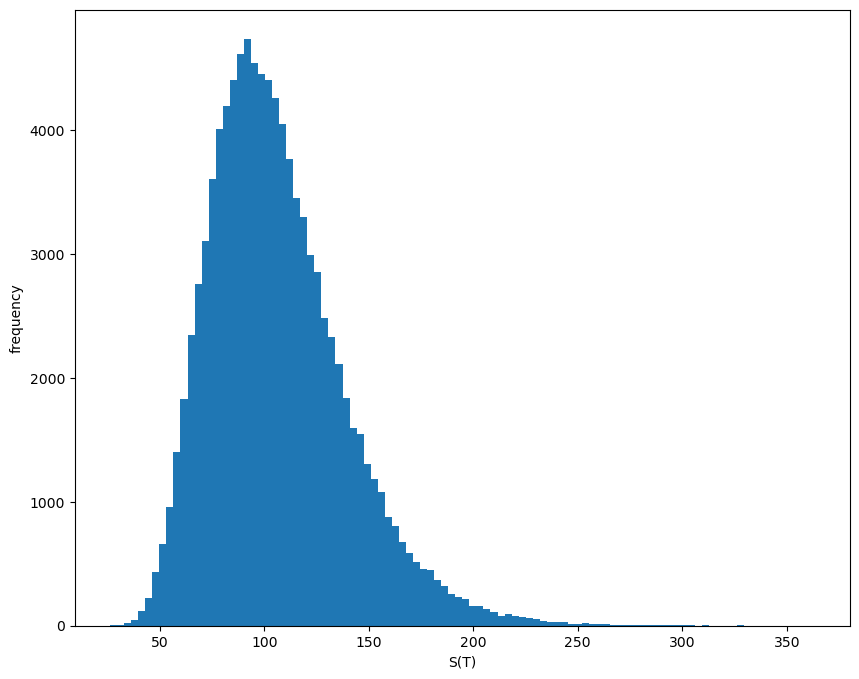

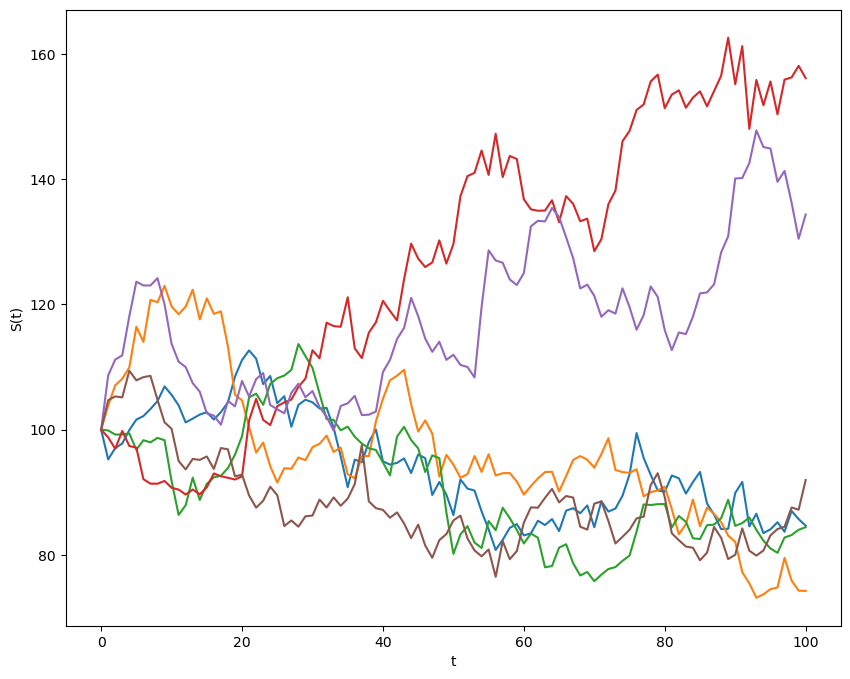

In [78]:
euler_discret(S0=100, T=1, sigma=0.3, r=0.06, M=100, Ite=100000, plot_prices = "T", plot_paths = "T")

Now implement Monte Carlo algorithm of European call option. Steps followed are:

    - Simulate stock price paths according to SDE dynamics
    - Calc. terminal option payoff for each path.
    - Obtain average expected payoff at maturity, T.
    - Discount average expected payoff to time t.

In [111]:
def bs_mc(S, K, r, sigma, T, t, Ite, option_type = "C", seed=42):
    data = np.zeros((Ite, 2)) #Initiate
    np.random.normal(seed)
    
    z = np.random.normal(0, 1, [1, Ite]) #Sample from N(0,1)
    
    #Future stock price
    ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
    
    #Payoff
    if option_type == "C": #Call option
        data[:, 1] = ST - K
    else: #Put option
        data[:, 1] = K - ST

    average = np.sum(np.amax(data, axis=1)) / float(Ite)

    return np.exp(-r * (T - t)) * average

In [83]:
print("Monte Carlo Price:", bs_mc(S=100, K=95, r=0.06, sigma=0.3, T=1, t=0, Ite=100000, option_type = "C"))

Monte Carlo Price: 17.263913133281264


### Convergence of Monte Carlo to Black-Scholes

In [113]:
print("BS Analytical Price:", bs_call_price(S=100.0, r=0.06, sigma=0.3, t=0, T=1, K=95))
print("Monte Carlo Price:", bs_mc(S=100, K=95, r=0.06, sigma=0.3, T=1, t=0, Ite=100000, option_type = "C"))

#Put
print("BS Analytical Price:", bs_put_price(S=118.75, r=0.015, sigma=0.25, t=0, T=18, K=122))
print("Monte Carlo Price:", bs_mc(S=118.75, K=122, r=0.015, sigma=0.25, T=18, t=0, Ite=5000, option_type = "P"))

BS Analytical Price: 17.323563283257634
Monte Carlo Price: 17.35673468850601
BS Analytical Price: 31.015222658625632
Monte Carlo Price: 30.215316931853742


C:\Users\lmmba\AppData\Local\Temp\ipykernel_29984\2938293965.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(


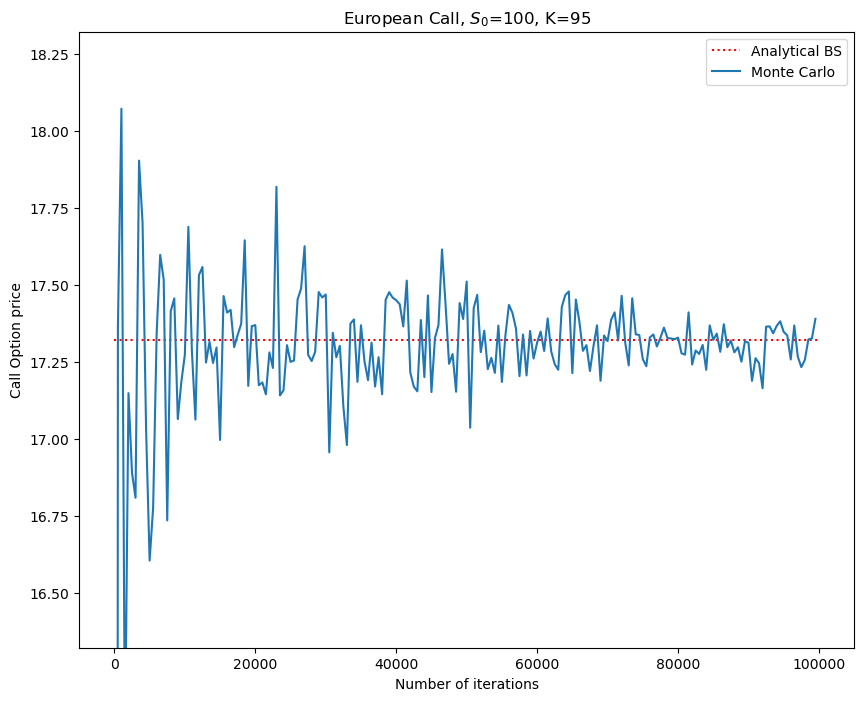

In [91]:
#Call Option convergence
df = pd.DataFrame(columns=["Iter", "BSc"])
 
for i in range(1, 100000, 500):
    df = pd.concat([df, pd.DataFrame(
    [{"Iter": i, "BSc": bs_mc(100,95,0.06,0.3,1,0,i,option_type="C")}])], ignore_index=True
    )

plt.figure(figsize=(10, 8))

plt.hlines(
    bs_call_price(100, 0.06, 0.3, 0, 1, 95),
    xmin=0,
    xmax=100000,
    linestyle="dotted",
    colors="red",
    label="Analytical BS",
)
plt.plot(df.set_index("Iter"), lw=1.5, label="Monte Carlo")

plt.title("European Call, $S_0$=100, K=95")
plt.xlabel("Number of iterations")
plt.ylabel("Call Option price")
plt.ylim(
    bs_call_price(100, 0.06, 0.3, 0, 1, 95) - 1,
    bs_call_price(100, 0.06, 0.3, 0, 1, 95) + 1,
)
plt.legend()
plt.show()

C:\Users\lmmba\AppData\Local\Temp\ipykernel_29984\551488023.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(


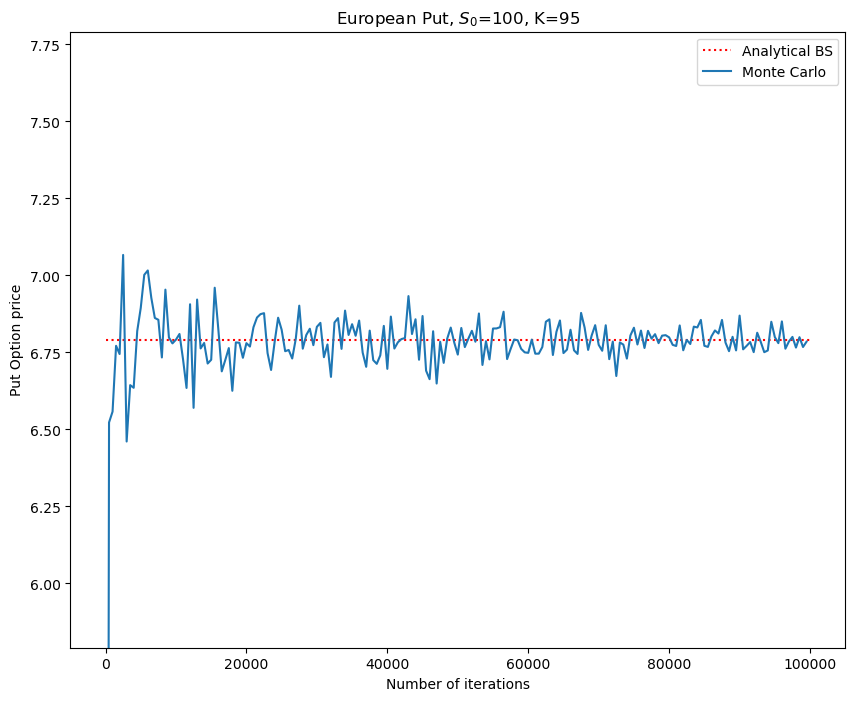

In [102]:
#Put Option convergence
df = pd.DataFrame(columns=["Iter", "BSc"])
 
for i in range(1, 100000, 500):
    df = pd.concat([df, pd.DataFrame(
    [{"Iter": i, "BSc": bs_mc(S=52, K=122, r=0.01, sigma=0.25, T=1, t=0, Ite=5000, option_type="P")}])], ignore_index=True
    )

plt.figure(figsize=(10, 8))

plt.hlines(
    bs_put_price(S=52, r=0.01, sigma=0.25, t=0, T=1, K=122),
    xmin=0,
    xmax=100000,
    linestyle="dotted",
    colors="red",
    label="Analytical BS",
)
plt.plot(df.set_index("Iter"), lw=1.5, label="Monte Carlo")

plt.title("European Put, $S_0$=100, K=95")
plt.xlabel("Number of iterations")
plt.ylabel("Put Option price")
plt.ylim(
    bs_put_price(100, 0.06, 0.3, 0, 1, 95) - 1,
    bs_put_price(100, 0.06, 0.3, 0, 1, 95) + 1,
)
plt.legend()
plt.show()

### Vasicek Model

The risk-neutral process for interest rates is:
$$dr = k(\theta - r)dt + \sigma dz$$
where $dz = \sqrt{dt} \times z$, with $z \sim N(0,1)$

In [105]:
def vasicek(r0, K, theta, sigma, T, N, M):
    dt = T / N
    t = np.linspace(0, T, N)
    rates = np.zeros((N, M)) #Initiate rates
    rates[0, :] = r0 #Initial rate
    
    for j in range(M):
        for i in range(1, N):
            #Risk-neutral process for interest rates
            dr = (
                K * (theta - rates[i - 1, j]) * dt
                + sigma * np.sqrt(dt) * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
            
    #Plot rates
    for j in range(M):
        plt.plot(t, rates[:, j])

    plt.xlabel("Time $t$", fontsize=14)
    plt.ylabel("$r(t)$", fontsize=14)
    plt.title("Vasicek Paths", fontsize=14)
    axes = plt.gca()
    axes.set_xlim([0, T])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

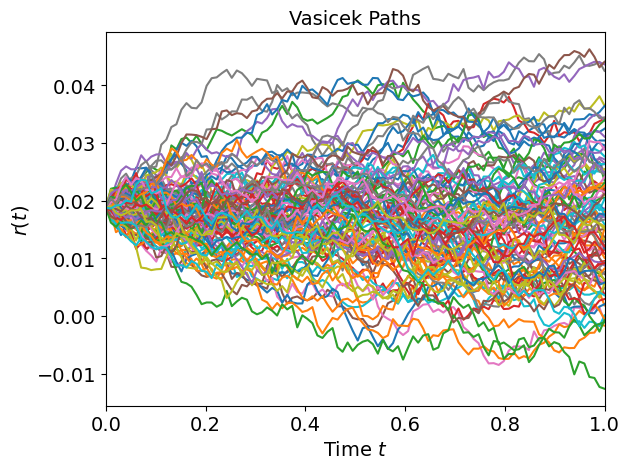

In [107]:
#M - no. of paths for MC
#N - no. of steps
#T - maturity
vasicek(r0=0.01875, K=0.20, theta=0.01, sigma=0.012, T=1, N=100, M=100)